In [557]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [558]:
data_ready = pd.read_csv("data_ready.csv")

In [559]:
data_ready[data_ready.select_dtypes(include=['float64']).columns] = data_ready.select_dtypes(include=['float64']).astype("float32")

In [560]:
data_ready = data_ready.sample(frac=1)

In [561]:
# 70% training data, 15% validation, 15% test
train_dev, test = train_test_split(data_ready, test_size=0.15, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.176, random_state=42)

In [562]:
# # Step 1: Separate majority and minority classes
# minority_class = train[train['5YR_SURV'] == 0]  # Adjust the condition based on your class labels
# majority_class = train[train['5YR_SURV'] == 1]

# # Step 2: Duplicate (oversample) the minority class
# oversample_minority = minority_class.sample(n=len(majority_class), replace=True)

# # Step 3: Combine the majority class with the oversampled minority class
# balanced_df = pd.concat([majority_class, oversample_minority])

# # Shuffle the dataset to mix up the rows
# train = balanced_df.sample(frac=1).reset_index(drop=True)

In [563]:
# convert to tensors and extract labels

train_label = train.pop("5YR_SURV")
dev_label = dev.pop("5YR_SURV")
test_label = test.pop("5YR_SURV")

train_tf = tf.convert_to_tensor(train)
dev_tf = tf.convert_to_tensor(dev)
test_tf = tf.convert_to_tensor(test)

train_label_tf = tf.convert_to_tensor(train_label)
dev_label_tf = tf.convert_to_tensor(dev_label)
test_label_tf = tf.convert_to_tensor(test_label)

In [564]:
from tensorflow.keras.initializers import GlorotUniform

In [565]:
model = tf.keras.Sequential(
    [
       tf.keras.Input(shape=(214,)),
       tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L1"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L3"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L15"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L5"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L9"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.003, l2=0.003), name="L11"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(1, activation="sigmoid", name="L13") 
    ]
)

In [566]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

In [567]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [568]:
from sklearn.utils import class_weight
y_train = np.array(train_label_tf)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the class weights into a dictionary with class labels as keys
class_weight_dict = dict(enumerate(class_weights))

In [569]:
history = model.fit(train_tf, train_label_tf, epochs=3000, batch_size=128, callbacks=[early_stopping], class_weight=class_weight_dict,validation_data = (dev_tf, dev_label_tf))

Epoch 1/3000


132/132 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5049 - auc_6: 0.4993 - loss: 56.3271 - recall_12: 0.5160 - val_accuracy: 0.7152 - val_auc_6: 0.5421 - val_loss: 55.7029 - val_recall_12: 0.9582
Epoch 2/3000
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5051 - auc_6: 0.4951 - loss: 55.7956 - recall_12: 0.5157 - val_accuracy: 0.6745 - val_auc_6: 0.5287 - val_loss: 55.1936 - val_recall_12: 0.8779
Epoch 3/3000
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5064 - auc_6: 0.5015 - loss: 55.2897 - recall_12: 0.5185 - val_accuracy: 0.6301 - val_auc_6: 0.5234 - val_loss: 54.7072 - val_recall_12: 0.7739
Epoch 4/3000
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5055 - auc_6: 0.5011 - loss: 54.7709 - recall_12: 0.5129 - val_accuracy: 0.5927 - val_auc_6: 0.5144 - val_loss: 54.2268 - val_recall_12: 0.7006
Epoch 5/3000
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5125 - auc_6: 0.5076 - loss: 54.2677 - recall_12: 0.5191 - val_accuracy: 0.5810 - val_auc_6:

In [570]:
# from sklearn.metrics import classification_report, roc_auc_score

# y_pred = model.predict(X_resampled)
# y_pred = y_pred.round()
# print("Classification Report:")
# print(classification_report(dev_label_tf, y_pred))
# print("ROC AUC Score:", roc_auc_score(dev_label_tf, y_pred))

In [571]:
from sklearn.metrics import precision_score, recall_score, f1_score


y_pred = model.predict(dev_tf)
y_pred = y_pred.round()

precision = precision_score(dev_label_tf, y_pred)
recall = recall_score(dev_label_tf, y_pred)
f1 = f1_score(dev_label_tf, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
recall_score(dev_label_tf, y_pred, pos_label=0)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Precision: 0.77
Recall: 0.68
F1-Score: 0.72


0.47653061224489796

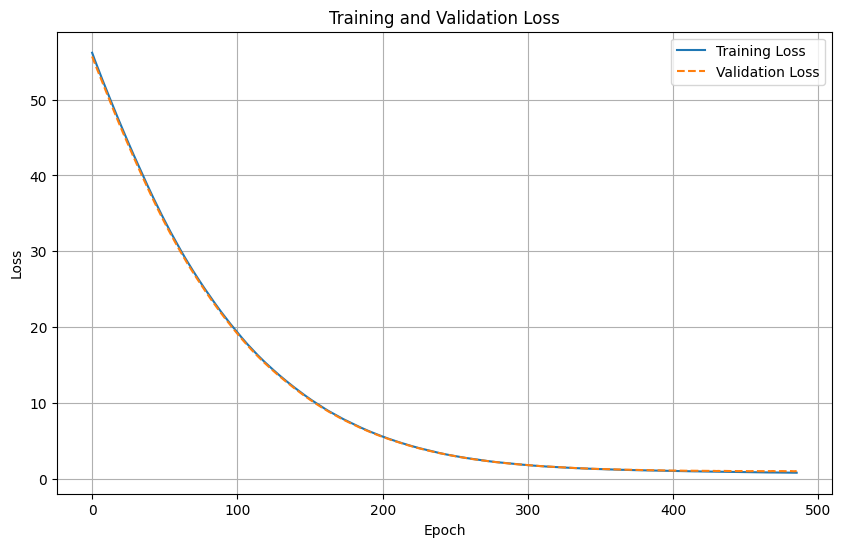

In [572]:
loss_values = history.history['loss']
val_loss_values = history.history.get('val_loss')

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
if val_loss_values:
    plt.plot(val_loss_values, label='Validation Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [573]:
model.evaluate(dev_tf, dev_label_tf)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6316 - auc_6: 0.6278 - loss: 0.9520 - recall_12: 0.6871


[0.961853563785553, 0.6223152279853821, 0.677159309387207, 0.6155899167060852]

In [574]:
from xgboost import XGBClassifier

In [575]:
# model = XGBClassifier(n_estimators=500, max_depth=6, subsample=0.7, colsample_bytree=0.7, learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0, scale_pos_weight=0.33, objective='binary:logistic')
# model.fit(X_resampled, y_resampled)
# print(model.score(train_tf, train_label_tf))
# print(model.score(dev_tf, dev_label_tf))
# y_pred = model.predict(dev_tf)

In [576]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# precision = precision_score(dev_label_tf, y_pred)
# recall = recall_score(dev_label_tf, y_pred)
# f1 = f1_score(dev_label_tf, y_pred)

# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")

In [577]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'reg_alpha': [0.01, 0.1, 1],
#     'reg_lambda': [0.01, 0.1, 1]
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
# grid_search.fit(np.array(train_tf), np.array(train_label_tf))

# print(f"Best Hyperparameters: {grid_search.best_params_}")
# print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")


In [578]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier

# model = LogisticRegression(max_iter=1000)
# model.fit(train_tf, train_label_tf)
# print(f"Logistic Regression Accuracy: {model.score(dev_tf, dev_label_tf) * 100:.2f}%")

# model = RandomForestClassifier(n_estimators=100)
# model.fit(train_tf, train_label_tf)
# print(f"Random Forest Accuracy: {model.score(dev_tf, dev_label_tf) * 100:.2f}%")
# model.predict(dev_tf)


# precision = precision_score(dev_label_tf, y_pred)
# recall = recall_score(dev_label_tf, y_pred)
# f1 = f1_score(dev_label_tf, y_pred)

# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-Score: {f1:.2f}")
# from sklearn.metrics import recall_score
# recall_score(dev_label_tf, y_pred, pos_label=0)